# 1. Install Dependencies and Setup

In [2]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib!
!pip install tensorflow tensorflow-gpu opencv-python matplotlib


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/92/2d/880fcd65e4414b05088193e6f2cfb86fdf90003dd2dd0f4d1bc465348f0e/tensorflow-2.15.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata (4.2 kB)
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "/Users/ravichandra/anaconda3/lib/python3.11/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/ravichandra/anaconda3/lib/python3.11/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          re

In [5]:
!pip list

Package                       Version
----------------------------- ------------
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.2.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
async-timeout

In [6]:
import tensorflow as tf
import os

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

/var/folders/zl/4drsp24x54xgwfxh2vd4qf9h0000gn/T/ipykernel_5996/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [11]:
data_dir = 'data' 

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

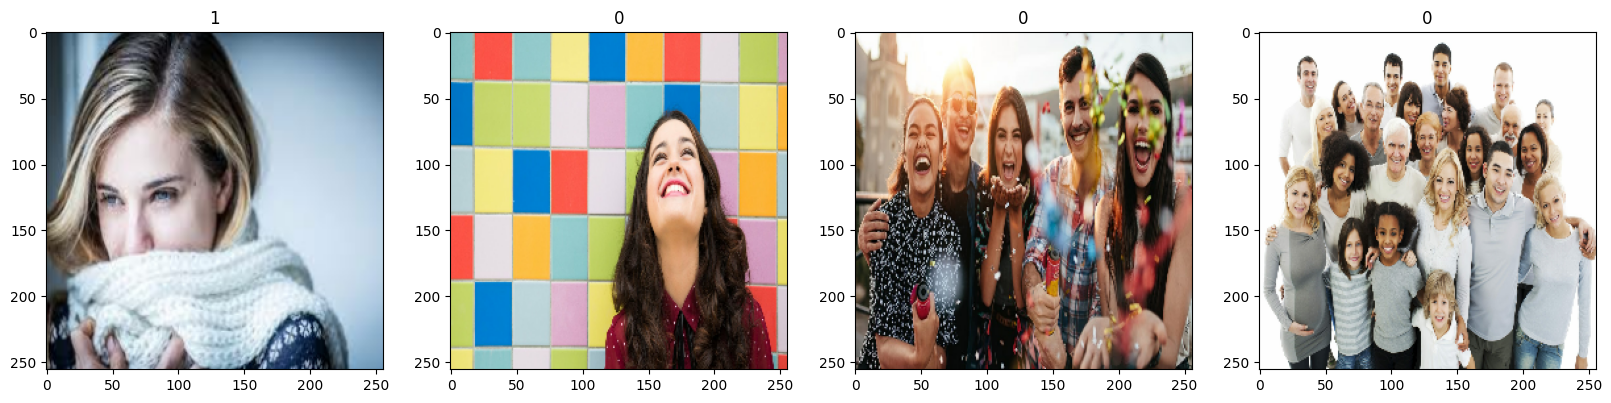

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.58431375, 0.5137255 , 0.35686275],
          [0.58465075, 0.5140625 , 0.35719976],
          [0.5861826 , 0.51559436, 0.35873163],
          ...,
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ]],
 
         [[0.58465075, 0.5140625 , 0.35719976],
          [0.5849588 , 0.51437056, 0.3575078 ],
          [0.586359  , 0.5157708 , 0.35890803],
          ...,
          [0.7865344 , 0.77084816, 0.75908345],
          [0.78627115, 0.7705849 , 0.7588202 ],
          [0.7862132 , 0.77052695, 0.75876224]],
 
         [[0.5861826 , 0.51559436, 0.35873163],
          [0.586359  , 0.5157708 , 0.35890803],
          [0.5871608 , 0.5165726 , 0.35970986],
          ...,
          [0.77880335, 0.7631171 , 0.75135237],
          [0.7773433 , 0.761657  , 0.7498923 ],
          [0.77702206, 0.7613358 , 0.7495711 ]],
 
         ...,
 
         [[0.0606924 , 0.0606924 , 0.05284926],
          [0.06102

# 5. Split Data

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

7

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.8740 - accuracy: 0.5134 - val_loss: 0.6933 - val_accuracy: 0.4219
Epoch 2/20
7/7 [==============================] - 8s 977ms/step - loss: 0.6757 - accuracy: 0.6339 - val_loss: 0.6451 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.6311 - accuracy: 0.6652 - val_loss: 0.5635 - val_accuracy: 0.6250
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.5426 - accuracy: 0.7277 - val_loss: 0.4690 - val_accuracy: 0.7812
Epoch 5/20
7/7 [==============================] - 9s 1s/step - loss: 0.4668 - accuracy: 0.7991 - val_loss: 0.4392 - val_accuracy: 0.8125
Epoch 6/20
7/7 [==============================] - 8s 948ms/step - loss: 0.4200 - accuracy: 0.8080 - val_loss: 0.3132 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 8s 924ms/step - loss: 0.3156 - accuracy: 0.8750 - val_loss: 0.2653 - val_accuracy: 0.8906
Epoch 8/20
7/7 [===============

# 8. Plot Performance

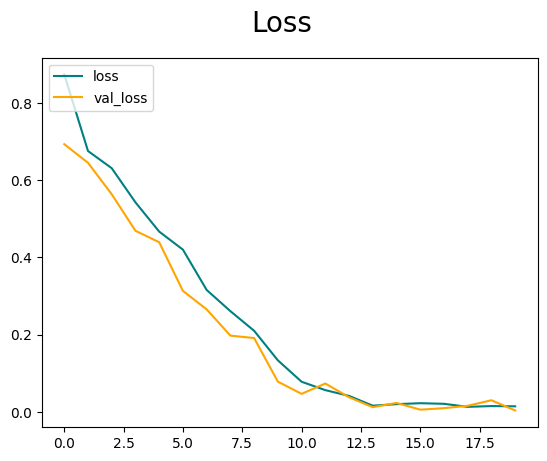

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

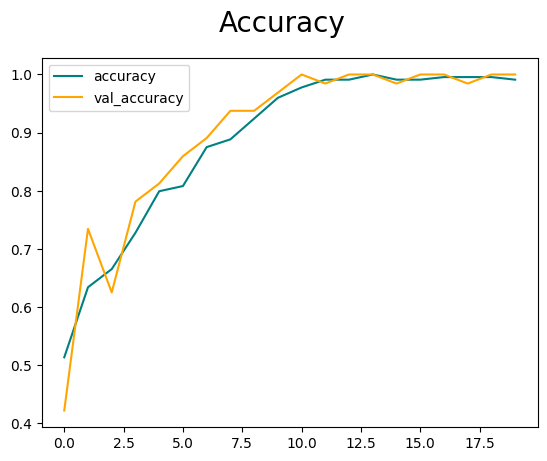

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 121ms/step


In [40]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [41]:
import cv2

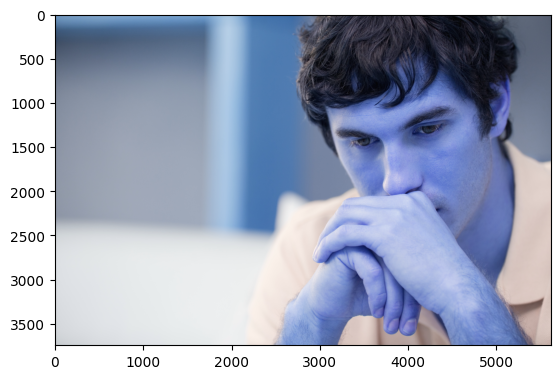

In [43]:
img = cv2.imread('/Users/ravichandra/Desktop/Image Classifier/ImageClassification/8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

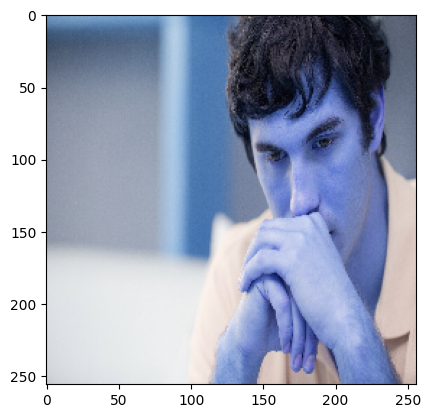

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [46]:
yhat

array([[0.9996486]], dtype=float32)

In [47]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [49]:
from tensorflow.keras.models import load_model

In [59]:
# model.save(os.path.join('models','Image.h5'))
from tensorflow.keras.models import load_model, save_model
import os

# Assuming 'models' directory exists. If not, create it.
model_directory = 'models'
os.makedirs(model_directory, exist_ok=True)

# Save the model
model.save(os.path.join(model_directory, 'Image.h5'))


In [60]:
# new_model = load_model('Image.h5')
# Load the model
loaded_model = load_model(os.path.join(model_directory, 'Image.h5'))


In [69]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [73]:
# new_model.predict(np.expand_dims(resize/255, 0))
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Assuming 'model' is your loaded model
model = load_model('models/Image.h5')

# Load and preprocess the image
img_path = '154006829.jpg'
target_size = (256, 256)  # Adjust this based on your model's input size

# Use Pillow's Image module to load and resize the image
img = Image.open(img_path)
img = img.resize(target_size)
resized_image = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape
input_data = np.expand_dims(resized_image / 255, 0)

# Make predictions
predictions = model.predict(input_data)

# Print or use the predictions as needed
print(predictions)



1/1 [==============================] - 0s 54ms/step
[[0.00424156]]


In [75]:
pip install streamlit

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached GitPython-3.1.40-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.6 MB/s eta 0:00:0000:0100:01
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 11.7 MB/s eta 0:00:00a 0:00:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached GitPython-3.1.40-py3-none-any.whl (190 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 4.0 MB/s eta 0:00:0000:0100:01
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [76]:
import streamlit as st
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Load your trained model
model = load_model('models/Image.h5')

# Set the target size based on your model's input size
target_size = (256, 256)

# Streamlit app
st.title("Image Classification with Streamlit")

# Upload image through Streamlit
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    # Preprocess the uploaded image
    img = Image.open(uploaded_file)
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    input_data = np.expand_dims(img_array / 255, 0)

    # Make predictions
    predictions = model.predict(input_data)

    # Display the results
    st.image(img, caption="Uploaded Image", use_column_width=True)
    st.write("Class predictions:")
    st.write(predictions)


2023-12-29 09:31:17.957 
  command:

    streamlit run /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
